In [9]:
import pickle
import xarray as xr
import cartopy as cp
import matplotlib.pyplot as plt
import numpy as np
import glob

import cartopy
from cartopy import crs, feature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from matplotlib.patches import Rectangle
import cmocean as cm

from scipy import interpolate

## open data

In [10]:
obs_ctd = glob.glob('./ForTereza/prepped_pyapnames/CTD/*.nc')
test_ctd = obs_ctd[0:20]
obs = xr.open_dataset(test_ctd[0])

In [11]:
scat = False

if scat:

    fact = 0.5
    fig, axs = plt.subplots(1,1, figsize=(27*fact, 8*fact), facecolor='w', edgecolor='k')

    # with open('./sampleda./ForTereza/prepped_pyapnames/11-03-08_2014h.pickle', 'rb') as pickle_file:
    #     model = pickle.load(pickle_file)
    bad_ctds = []
    for i in range(0, len(obs_ctd)):
        if i%100 == 0:
            print(i)
        try:
            obs = xr.open_dataset(obs_ctd[i])
            ttime = (obs['time'].values)
            tobs = len(obs['Pres'].values)
            t = np.empty(tobs, dtype='datetime64[s]')
            t[:] = ttime[0]


            w =axs.scatter(t, obs['Pres'].values, c = obs['cTemp'].values, s = 10, vmin = 5, vmax = 20)

        except:
            bad_ctds.append(obs_ctd[i])


    axs.invert_yaxis()


### need ctds sorted by date, for processing

In [12]:

ctd_bydate = []
for i in range(0,len(obs_ctd)):
    my_string = obs_ctd[i]
    datestr = (my_string.split("CTD_",1)[1]) #get the stuff after CTD
    ctd_bydate.append(datestr)
    
ctd_bydate.sort()
print('first 5 date substrings from ctd file names,  to check if sorting worked')
print(ctd_bydate[0:5])

first 5 date substrings from ctd file names,  to check if sorting worked
['1969-02-11_1835h.nc', '1969-02-11_2010h.nc', '1969-02-28_1725h.nc', '1969-02-28_2000h.nc', '1969-03-03_1725h.nc']


## get model depths

In [13]:
# tmodel = glob.glob('./ForTereza/CTD/*.pickle')
# # print(len(tmodel))

tmodel = xr.open_dataset('./clippedData/SalishSea1500-RUN203_1h_grid_T_y1990m04_clipped.nc')
mod_depth = tmodel['deptht']
# with open(tmodel[0], 'rb') as pickle_file:
#     model = pickle.load(pickle_file)
    
# mod_depth = (model['z'])
# #create unmasked model depth array to be able to interpolate
modd_um = np.zeros(40)
for i in range(0,40):
    modd_um[i] = mod_depth[i]

## write a function that will interpolate t and s to model depths and test it 

if verbose == True here, it prints out pictures to show what it's doing

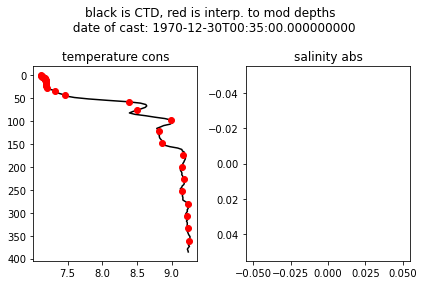

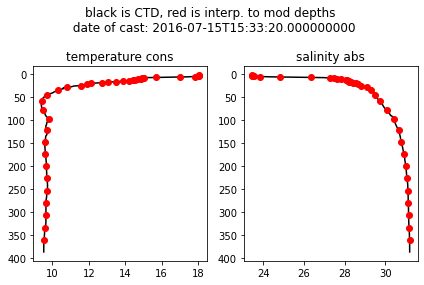

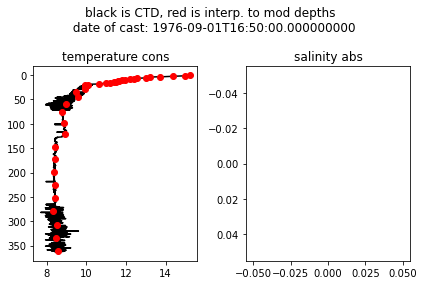

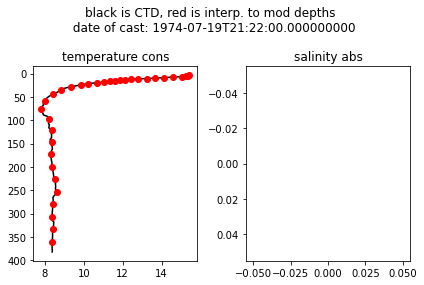

In [22]:

def get_model_interpolated(ncname, verbose = True):

    tobs = xr.open_dataset(ncname)
    obs_d = tobs['Pres'].values
    obs_t = tobs['cTemp'].values
    obs_s = tobs['aSal'].values
    ttime = tobs['time'][0].values

    try:
        f = interpolate.interp1d(obs_d, obs_t) #temperature
        f2 = interpolate.interp1d(obs_d, obs_s) #salinity

        ## can only interpolate to model points that are within observations 
        mod_d = modd_um[(modd_um<max(obs_d)) & (modd_um>min(obs_d))]
        firstind = np.where(modd_um == np.min(mod_d))[0][0] ## first model index we were able to interpolate to 
        interp_t = f(mod_d)   # use interpolation function returned by `interp1d`
        interp_s = f2(mod_d)

        ### 
        t_full = np.zeros(40)
        t_full[:] = -999
        t_full[firstind:firstind+len(mod_d)] = interp_t
        t_full[t_full < -900] = np.nan

        s_full = np.zeros(40)
        s_full[:] = -999
        s_full[firstind:firstind+len(mod_d)] = interp_s
        s_full[s_full < -900] = np.nan



        if verbose:
            fig, axs =  plt.subplots(1,2)
            axs = axs.ravel()
            axs[0].plot(obs_t, obs_d, 'k-', interp_t, mod_d, 'or')
            axs[1].plot(obs_s, obs_d, 'k-', interp_s, mod_d, 'or')
            axs[0].set_title('temperature cons')
            axs[1].set_title('salinity abs')
            axs[0].invert_yaxis()
            axs[1].invert_yaxis()

            fig.suptitle(f'black is CTD, red is interp. to mod depths \n date of cast: {ttime}')
            plt.tight_layout()
            plt.show()
    except:
               
        t_full = np.zeros(40)
        t_full[:] = -999
        t_full[t_full < -900] = np.nan
        s_full = np.zeros(40)
        s_full[:] = -999
        s_full[s_full < -900] = np.nan
        
    return t_full, s_full, ttime

for i in range(0,4):
    t_full, s_full, ttime  = get_model_interpolated(obs_ctd[i])


In [24]:
extract = False
if extract:
    time_array = np.empty(len(ctd_bydate), dtype='datetime64[s]')
    salt_array = np.zeros([len(ctd_bydate), 40])
    temp_array = np.zeros([len(ctd_bydate), 40])

    for i in range(0,len(ctd_bydate)):
        print(f'{i}, {ctd_bydate[i]}')
        tstr = glob.glob(f'./ForTereza/prepped_pyapnames/CTD/*{ctd_bydate[i]}')[0]
        t_full, s_full, ttime  = get_model_interpolated(tstr, verbose = False)

        salt_array[i,:] = s_full
        temp_array[i,:] = t_full
        time_array[i] = ttime

        pickle.dump(salt_array, open("CTD-salt_array.pkl", 'wb'))
        pickle.dump(temp_array, open("CTD-temp_array.pkl", 'wb'))
        pickle.dump(time_array, open("CTD-time_array.pkl", 'wb'))

#t_full, s_full, ttime  = get_model_interpolated(obs_ctd[i])


In [31]:
time_array[0].month

AttributeError: 'numpy.datetime64' object has no attribute 'month'

In [33]:
temp_array = pickle.load(open('./CTD-temp_array.pkl', 'rb'))
salt_array = pickle.load(open('./CTD-salt_array.pkl', 'rb'))
time_array = pickle.load(open('./CTD-time_array.pkl', 'rb'))

In [35]:
print(np.shape(temp_array))

(5692, 40)


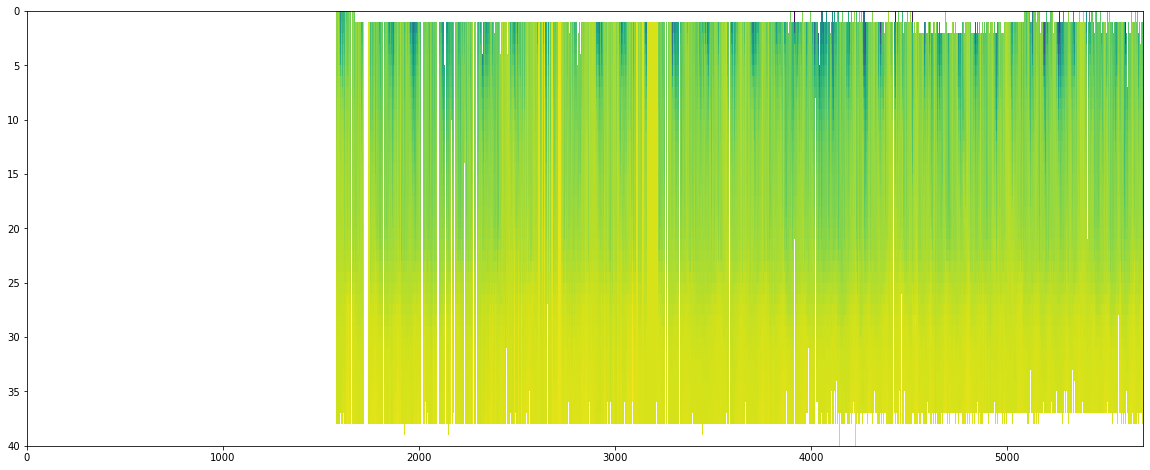

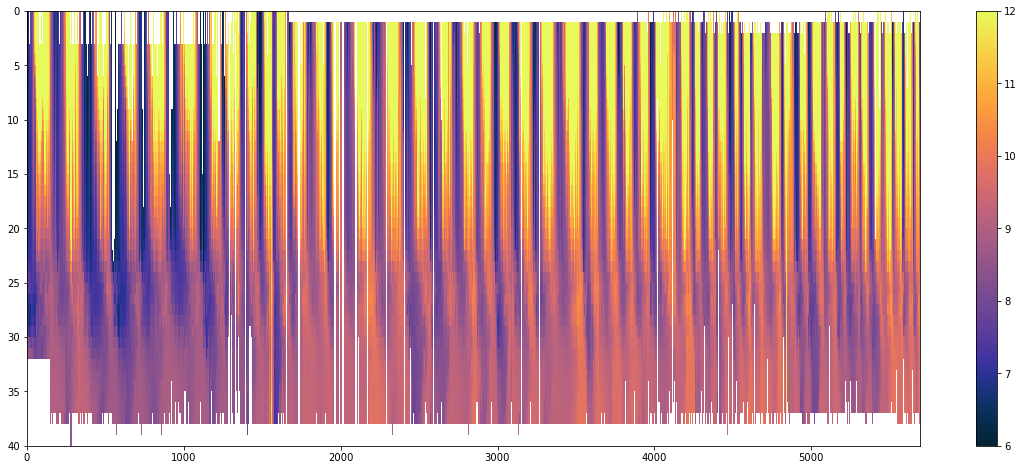

In [36]:
fig, axs = plt.subplots(figsize = (20,8))
w = plt.pcolormesh(np.transpose(salt_array))
axs.invert_yaxis()

fig, axs = plt.subplots(figsize = (20,8))
w = plt.pcolormesh(np.transpose(temp_array), vmin = 6, vmax = 12, cmap = cm.cm.thermal)
plt.colorbar(w, ax = axs)
axs.invert_yaxis()

In [37]:
import pandas as pd
dates_obs = pd.DatetimeIndex(time_array)
obs_yrs = dates_obs.year; obs_months = dates_obs.month; obs_days = dates_obs.day

# print(dates[0])
# print(dates[-1])
dates_all = pd.date_range(start='1969-01-01', end= '2018-12-31', freq='D')

dates_yrs = dates_all.year; dates_months = dates_all.month; dates_days = dates_all.day

print(len(dates_all))
salt_ts = np.zeros([len(dates_all), 40]); salt_ts[:] = -999
temp_ts = np.zeros([len(dates_all), 40]); temp_ts[:] = -999

for i in range(0, len(dates_all)):
    find_obs = np.where((obs_yrs == dates_yrs[i]) & (obs_months == dates_months[i]) & (obs_days == dates_days[i]))
    if (len(dates_obs[find_obs])>0):
        
        salt_ts[i,:] = np.nanmean(np.squeeze(salt_array[find_obs,:]), axis = 0)
        temp_ts[i,:] = np.nanmean(np.squeeze(temp_array[find_obs,:]), axis = 0)

18262


/gpfs/home/mep22dku/.conda/envs/swamp2/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: Mean of empty slice
/gpfs/home/mep22dku/.conda/envs/swamp2/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: Mean of empty slice


next task
- convert to xarray


TypeError: Dimensions of C (39, 18262) are incompatible with X (18262) and/or Y (40); see help(pcolormesh)

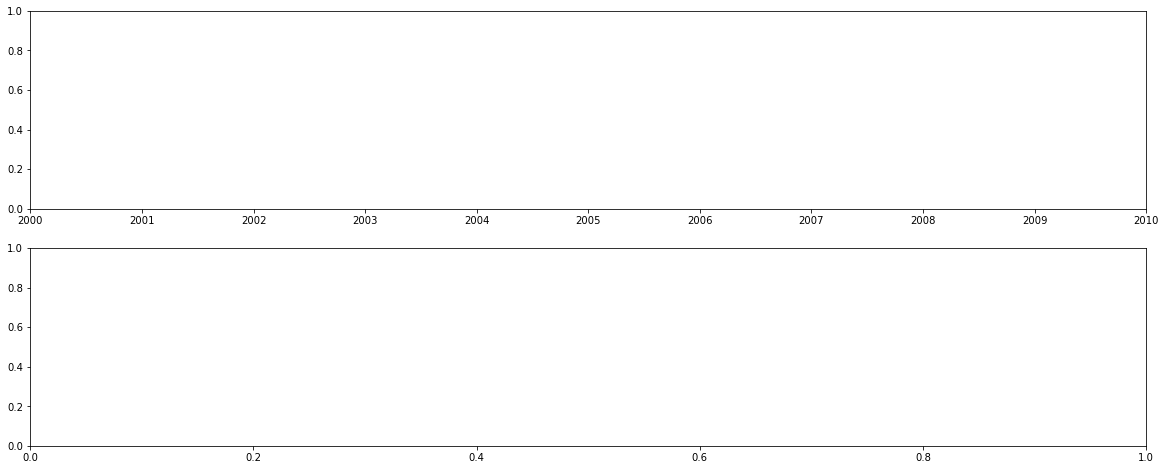

In [32]:
fig, axs = plt.subplots(2, 1, figsize = (20,8))
axs = axs.ravel()
temp_ts[temp_ts <-900] = np.nan
w = axs[0].pcolormesh(dates_all, modd_um, np.transpose(temp_ts), vmin=5, vmax=15, cmap = cm.cm.thermal)
plt.colorbar(w, ax = axs[0])
axs[0].invert_yaxis()

salt_ts[salt_ts <-900] = np.nan
w = axs[1].pcolormesh(dates_all, modd_um, np.transpose(salt_ts), vmin=28, vmax=31, cmap = cm.cm.haline)
plt.colorbar(w, ax = axs[1])
axs[1].invert_yaxis()
axs[0].set_title('Observational Temperature Hövmoller (cons T) at Nanoose Bay \n (daily resolution, interpolated to model depths, all casts for given day averaged)')
axs[1].set_title('Observational Salinity Hövmoller (abs S, g/kg) at Nanoose Bay')

plt.tight_layout()


In [ ]:
import pandas as pd
dates_obs = pd.DatetimeIndex(time_array)
obs_yrs = dates_obs.year; obs_months = dates_obs.month; obs_days = dates_obs.day

# print(dates[0])
# print(dates[-1])
dates_yr = pd.date_range(start='1969-01-01', end= '1970-01-01', freq='D')

dates_months = dates_yr.month; dates_days = dates_yr.day

print(len(dates_all))
salt_clim = np.zeros([366, 39]); salt_clim[:] = -999
temp_clim = np.zeros([366, 39]); temp_clim[:] = -999

for i in range(0, 366):
    find_obs = np.where((obs_months == dates_months[i]) & (obs_days == dates_days[i]))
    if (len(dates_obs[find_obs])>0):
        
        salt_clim[i,:] = np.nanmean(np.squeeze(salt_array[find_obs,:]), axis = 0)
        temp_clim[i,:] = np.nanmean(np.squeeze(temp_array[find_obs,:]), axis = 0)

In [ ]:
fig, axs = plt.subplots(2, 1, figsize = (20,8))
axs = axs.ravel()
temp_clim[temp_clim <-900] = np.nan
w = axs[0].pcolormesh(np.arange(1,367,1), modd_um, np.transpose(temp_clim), vmin=5, vmax=15, cmap = cm.cm.thermal)
plt.colorbar(w, ax = axs[0])
axs[0].invert_yaxis()

salt_clim[salt_clim <-900] = np.nan
w = axs[1].pcolormesh(np.arange(1,367,1), modd_um, np.transpose(salt_clim), vmin=28, vmax=31, cmap = cm.cm.haline)
plt.colorbar(w, ax = axs[1])
axs[1].invert_yaxis()
axs[0].set_title('Observational Temperature Climatology 1969-2018 (cons T) at Nanoose Bay \n (daily resolution, interpolated to model depths, all casts for given day averaged)')
axs[1].set_title('Observational Salinity Climatology (abs S, g/kg) at Nanoose Bay')

plt.tight_layout()


In [ ]:
fig, axs = plt.subplots(2, 1, figsize = (20,8))
axs = axs.ravel()
temp_ts[temp_ts <-900] = np.nan
w = axs[0].pcolormesh(dates_all, modd_um, np.transpose(temp_ts), vmin=5, vmax=15, cmap = cm.cm.thermal)
plt.colorbar(w, ax = axs[0])


salt_ts[salt_ts <-900] = np.nan
w = axs[1].pcolormesh(dates_all, modd_um, np.transpose(salt_ts), vmin=28, vmax=31, cmap = cm.cm.haline)
plt.colorbar(w, ax = axs[1])

axs[0].set_title('Observational Temperature Hövmoller (cons T) at Nanoose Bay \n (daily resolution, interpolated to model depths, all casts for given day averaged)')
axs[1].set_title('Observational Salinity Hövmoller (abs S, g/kg) at Nanoose Bay')

axs[0].set_xlim([4300,4700])
axs[1].set_xlim([4300,4700])
axs[0].set_ylim([0,10])
axs[1].set_ylim([0,10])

axs[0].invert_yaxis()
axs[1].invert_yaxis()


In [ ]:
x = [-3, -2, -1.6, -1.2, -.8, -.5, -.2, .1, .3, .5, .8, 1.1, 1.5, 1.9, 2.3, 3]
X, Y = np.meshgrid(x, np.linspace(-5, 5, 128))
Z = (1 - X/2 + X**5 + Y**3) * np.exp(-X**2 - Y**2)

# plot
fig, ax = plt.subplots()
ax.pcolormesh(X, Y, Z, vmin=-0.5, vmax=1.0)

####
X, Y = np.meshgrid(dates_all, modd_um)
fig, ax = plt.subplots()
temp_ts[temp_ts == 0] = np.nan
ax.pcolormesh(X, Y, np.transpose(temp_ts), vmin=-0.5, vmax=1.0)
# fig, ax = plt.subplots()
# ax.pcolormesh(modd_um, dates_all, salt_ts, vmin=-0.5, vmax=1.0)


In [ ]:
testdat = xr.open_dataset(obs_ctd[0])
print(testdat)

In [ ]:
fig.savefig('raw_ctd_nanoose.jpg')

In [ ]:


obs = xr.open_dataset('./sampledat/Nanoose_9_CastCTD_2011-03-08_2014h.nc')

obs

In [ ]:
model

# plot ctd location on standard map and on subset

In [ ]:


subdomain = [114, 397, 334, 897]
fig = plt.figure(figsize=(9, 7))
gs = plt.GridSpec(1, 1)#, width_ratios=[1.8, 1], wspace=0.13)

# Map Left
xlim, ylim = [-126.5, -121.2], [46.8, 51.2]
ax = fig.add_subplot(gs[0], projection=crs.Mercator(np.mean(xlim), *ylim))
ax.set_extent(xlim + ylim)
#full (low for easy render)
ax.add_feature(feature.GSHHSFeature('low', edgecolor='k', facecolor='burlywood'))

xlocs, ylocs = [np.arange(np.floor(l[0]), np.ceil(l[1])+1) for l in [xlim, ylim]]
gl = ax.gridlines(linestyle=":", color='k', draw_labels=True, xlocs=xlocs, ylocs=ylocs)
gl.xformatter, gl.yformatter = LONGITUDE_FORMATTER, LATITUDE_FORMATTER
gl.xlabels_top, gl.ylabels_right = False, False

ax.text(0.15, 0.1, 'Pacific\nOcean', weight='bold', fontsize = 12, transform=ax.transAxes)
ax.text(0.32, 0.307, 'Juan de Fuca', weight='bold', transform=ax.transAxes, rotation=-19.5)
ax.text(0.555, 0.305, 'Strait', weight='bold', transform=ax.transAxes, rotation=10.5)
ax.text(0.82, 0.18, 'Puget\nSound', weight='bold', transform=ax.transAxes)

ax.text(0.355, 0.4851, 'Strait of Georgia', weight='bold', transform=ax.transAxes, rotation=-30, color='w')
#ax.text(0.010, 0.755, 'Johnstone', weight='bold', transform=ax.transAxes, rotation=-20)
ax.text(0.015, 0.740, 'Johnstone \n Strait ', weight='bold', transform=ax.transAxes, rotation=-0)
#ax.text(0.16, 0.675, 'Strait', weight='bold', transform=ax.transAxes, rotation=-60)

ax.text(0.44, 0.38, 'Haro\nStrait', weight='bold', transform=ax.transAxes)


ax.text(0.72, 0.55, 'Fraser\nRiver', weight='bold', transform=ax.transAxes)
ax.text(0.35, 0.9, 'Bute Inlet', weight='bold', transform=ax.transAxes)
ax.text(0.42, 0.80, 'Toba Inlet', weight='bold', transform=ax.transAxes)
ax.text(0.53, 0.75, 'Jervis Inlet', weight='bold', transform=ax.transAxes)
ax.text(0.60, 0.67, 'Howe Sound', weight='bold', transform=ax.transAxes)
ax.text(0.11, 0.64, 'Texada Island', weight='bold',fontstyle="italic", 
        color = 'k', fontsize = 10, transform=ax.transAxes)


ax.plot(obs['longitude'][:], obs['latitude'][:], 'ro', transform=crs.PlateCarree())


#Map Inset
xmap, ymap = [-161, -122], [45, 62]
ax2 = fig.add_axes([0.555, 0.75, 0.24, 0.2], projection=crs.LambertConformal(np.mean(xmap), np.mean(ymap)))
ax2.set_extent(xmap + ymap)
ax2.add_feature(feature.GSHHSFeature('low', edgecolor='k', facecolor='darkgray'))
ax2.add_patch(Rectangle(
    (xlim[0], ylim[0]), int(np.diff(xlim)), int(np.diff(ylim)),
    transform=crs.PlateCarree(), fill=False, edgecolor='r', zorder=10,
))



ax2.text(0.34, 0.5, 'Gulf of\nAlaska', transform=ax2.transAxes)
ax2.text(0.77, 0.55, 'Canada', transform=ax2.transAxes)
ax2.text(0.15, 0.9, 'USA', transform=ax2.transAxes)



xticks, yticks = list(range(-170, -100, 10)), list(range(40, 80, 10))
ax2.gridlines(linestyle=":", color='k', xlocs=xticks, ylocs=yticks)
ax2.xaxis.set_major_formatter(LONGITUDE_FORMATTER) 
ax2.yaxis.set_major_formatter(LATITUDE_FORMATTER)
fig.canvas.draw()

#ax.set_title('Nanoose CTD observation location (red) \n on standard Salish Sea map',zorder = 100)

#lct.lambert_xticks(ax, xticks)
#lct.lambert_yticks(ax, yticks)

# # Colorbar
# cax = fig.add_axes([0.15, 0.06, 0.73, 0.025])
# fig.colorbar(c, cax=cax, orientation='horizontal', label='surface diatom concentration (mmol N m$^{-3}$)')

# fig.savefig('./paper_figs/MF01-domain.jpg', bbox_inches='tight', dpi = 300)

In [ ]:


subdomain = [114, 397, 334, 897]
fig = plt.figure(figsize=(9, 7))
gs = plt.GridSpec(1, 1)#, width_ratios=[1.8, 1], wspace=0.13)

# Map Left
xlim, ylim = [-124.5, -123.2], [48.5, 50]
ax = fig.add_subplot(gs[0], projection=crs.Mercator(np.mean(xlim), *ylim))
ax.set_extent(xlim + ylim)
#full (low for easy render)
ax.add_feature(feature.GSHHSFeature('full', edgecolor='k', facecolor='burlywood'))


    
xlocs, ylocs = [np.arange(np.floor(l[0]), np.ceil(l[1])+1) for l in [xlim, ylim]]
gl = ax.gridlines(linestyle=":", color='k', draw_labels=True, xlocs=xlocs, ylocs=ylocs)
gl.xformatter, gl.yformatter = LONGITUDE_FORMATTER, LATITUDE_FORMATTER
gl.xlabels_top, gl.ylabels_right = False, False


ax.plot(obs['longitude'][:], obs['latitude'][:], 'ro', transform=crs.PlateCarree())

fig.canvas.draw()

ax.set_title('Nanoose CTD observation location (red) \n in Strait of Georgia',zorder = 100)

#lct.lambert_xticks(ax, xticks)
#lct.lambert_yticks(ax, yticks)

# # Colorbar
# cax = fig.add_axes([0.15, 0.06, 0.73, 0.025])
# fig.colorbar(c, cax=cax, orientation='horizontal', label='surface diatom concentration (mmol N m$^{-3}$)')

# fig.savefig('./paper_figs/MF01-domain.jpg', bbox_inches='tight', dpi = 300)

### ctd measurements

In [ ]:
model

fact = 0.7
fig, axs = plt.subplots(1,2, figsize=(12*fact, 8*fact), facecolor='w', edgecolor='k')
axs = axs.ravel()

axs[0].plot(obs['cTemp'], obs['Pres'], 'r-', label = 'obs. (conservative?)')
axs[0].plot(model['pTemp'], model['z'], 'r:',  label = 'model (potential)')
axs[0].invert_yaxis()
axs[0].legend()
axs[0].set_title('temperature')

axs[1].plot(obs['salinity'], obs['Pres'], 'r-', label = 'obs. (psu?)')
axs[1].plot(model['salinity'], model['z'], 'r:',  label = 'model (g/kg)')
axs[1].invert_yaxis()
axs[1].legend()
axs[1].set_title('salinity')

axs[0].set_ylabel('depth (m)')
axs[0].set_xlabel('temperature $^{\circ}$C')
axs[1].set_xlabel('salinity')